In [1]:
import os

import numpy as np
import pandas as pd
import glob

import pygrib

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 

In [2]:
datetime=20240813
top_level_grib=5
top_level_rrfs=18
subsample_factor=5
plot_var = "Press_diff"
gribfile="/work/noaa/wrfruc/span/jedi_summer_retro/HRRR_gribfiles/hrrr.t18z.wrfnatf01." + str(datetime) + ".grib2"
rrfsfiles = glob.glob("/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/2024081318/local_lapse_rate_*.txt")

In [3]:
hrrr={}

# Open the GRIB2 file
grbs = pygrib.open(gribfile)

# Extract the latitudes and longitudes (they are part of the grid attributes)
hrrr["Lats"], hrrr["Lons"] = grbs[1].latlons()

print("Shape: ", hrrr["Lats"].shape)
print("Latitude: ", hrrr["Lats"])
print("Longitude: ", hrrr["Lons"])

# Extract height at level 1 (usually surface or near-surface)
grb_level_1 = grbs.select(name='Geopotential height', level=1)[0]
height_1 = grb_level_1.values

# Extract height at top_level_grib
grb_level_top = grbs.select(name='Geopotential height', level=top_level_grib)[0]
height_top = grb_level_top.values

hrrr["Height_diff"] = height_top - height_1

# Print the extracted height data
print(f"Height Differences: {hrrr["Height_diff"]}")

# Extract pressure at level 1 (usually surface or near-surface)
grb_level_1 = grbs.select(name='Pressure', level=1)[0]  # Level 1 often corresponds to surface pressure
pressure_1 = grb_level_1.values / 100.

# Extract pressure at top_level_grib
grb_level_top = grbs.select(name='Pressure', level=top_level_grib)[0]  # For example, level 5 is 500 hPa pressure
pressure_top = grb_level_top.values / 100.

hrrr["Press_diff"] = pressure_1 - pressure_top

# Print the extracted pressure data
print(f"Pressure Differences: {hrrr["Press_diff"]}")

# Extract temperature at level 1 (usually surface or near-surface)
grb_level_1 = grbs.select(name='Temperature', level=1)[0]  # Level 1 often corresponds to surface pressure
temperature_1 = grb_level_1.values

# Extract pressure at top_level_grib
grb_level_top = grbs.select(name='Temperature', level=top_level_grib)[0]  # For example, level 5 is 500 hPa pressure
temperature_top = grb_level_top.values

temperature_differences_hrrr = temperature_1 - temperature_top
hrrr["Lapserate"] = temperature_differences_hrrr * 1000 / hrrr["Height_diff"]

# Print the derived lapse rate data
print(f"Lapse Rate: {hrrr["Lapserate"]}")

# Close the GRIB2 file
grbs.close()

Shape:  (1059, 1799)
Latitude:  [[21.138123   21.14511004 21.1520901  ... 21.1545089  21.14753125
  21.14054663]
 [21.16299459 21.1699845  21.17696744 ... 21.17938723 21.1724067
  21.16541921]
 [21.18786863 21.19486142 21.20184723 ... 21.20426802 21.19728462
  21.19029425]
 ...
 [47.78955926 47.799849   47.81012868 ... 47.81369093 47.80341474
  47.79312849]
 [47.81409316 47.82438621 47.8346692  ... 47.83823259 47.8279531
  47.81766354]
 [47.8386235  47.84891986 47.85920615 ... 47.86277069 47.85248789
  47.84219502]]
Longitude:  [[-122.719528   -122.69286132 -122.6661903  ...  -72.3430592
   -72.31638668  -72.28971849]
 [-122.72702499 -122.70035119 -122.67367305 ...  -72.33557892
   -72.30889927  -72.28222397]
 [-122.73452632 -122.7078454  -122.68116014 ...  -72.3280943
   -72.30140753  -72.2747251 ]
 ...
 [-134.0648096  -134.02828423 -133.99174671 ...  -61.02092594
   -60.9843842   -60.94785462]
 [-134.08013858 -134.04360126 -134.00705178 ...  -61.00562502
   -60.96907132  -60.93252978

In [4]:
# Initialize an empty list to store dataframes
dataframes = []

# Loop through all files
for file in rrfsfiles:
    # Read the file into a pandas dataframe
    df = pd.read_csv(file, sep=r'\s+', header=None, 
                     names=["Index", "Lats", "Lons", "Press_bl", "Press_bt", "Height_bt", 
                            "Height_bl", "Press_diff", "Height_diff", "Lapserate"])

    # Drop duplicate rows based on the 'Index' column (keeping the first occurrence)
    df_unique = df.drop_duplicates(subset="Index", keep="first")
    
    # Append the filtered dataframe to the list
    dataframes.append(df_unique)

# Concatenate all dataframes into a single dataframe
rrfs_df = pd.concat(dataframes, ignore_index=True)
rrfs_df['Lons'] = rrfs_df['Lons'].apply(lambda x: x - 360 if x > 180 else x)

print("Latitude: ", rrfs_df["Lats"].to_numpy())
print("Longitude: ", rrfs_df["Lons"].to_numpy())
print(f"Height Differences: {rrfs_df["Height_diff"].to_numpy()}")
print(f"Pressure Differences: {rrfs_df["Press_diff"].to_numpy()}")
print(f"Lapse Rate: {rrfs_df["Lapserate"].to_numpy()}")

Latitude:  [25.9   27.63  28.52  ... 32.693 42.403 41.449]
Longitude:  [-80.28  -90.44  -88.29  ... -83.649 -90.709 -90.508]
Height Differences: [1056.729 1051.121 1052.33  ... 1056.988 1023.79  1026.826]
Pressure Differences: [113.968 114.27  114.225 ... 112.323 110.557 111.481]
Lapse Rate: [ 9.534  7.961  7.94  ... 10.722 10.135 10.361]


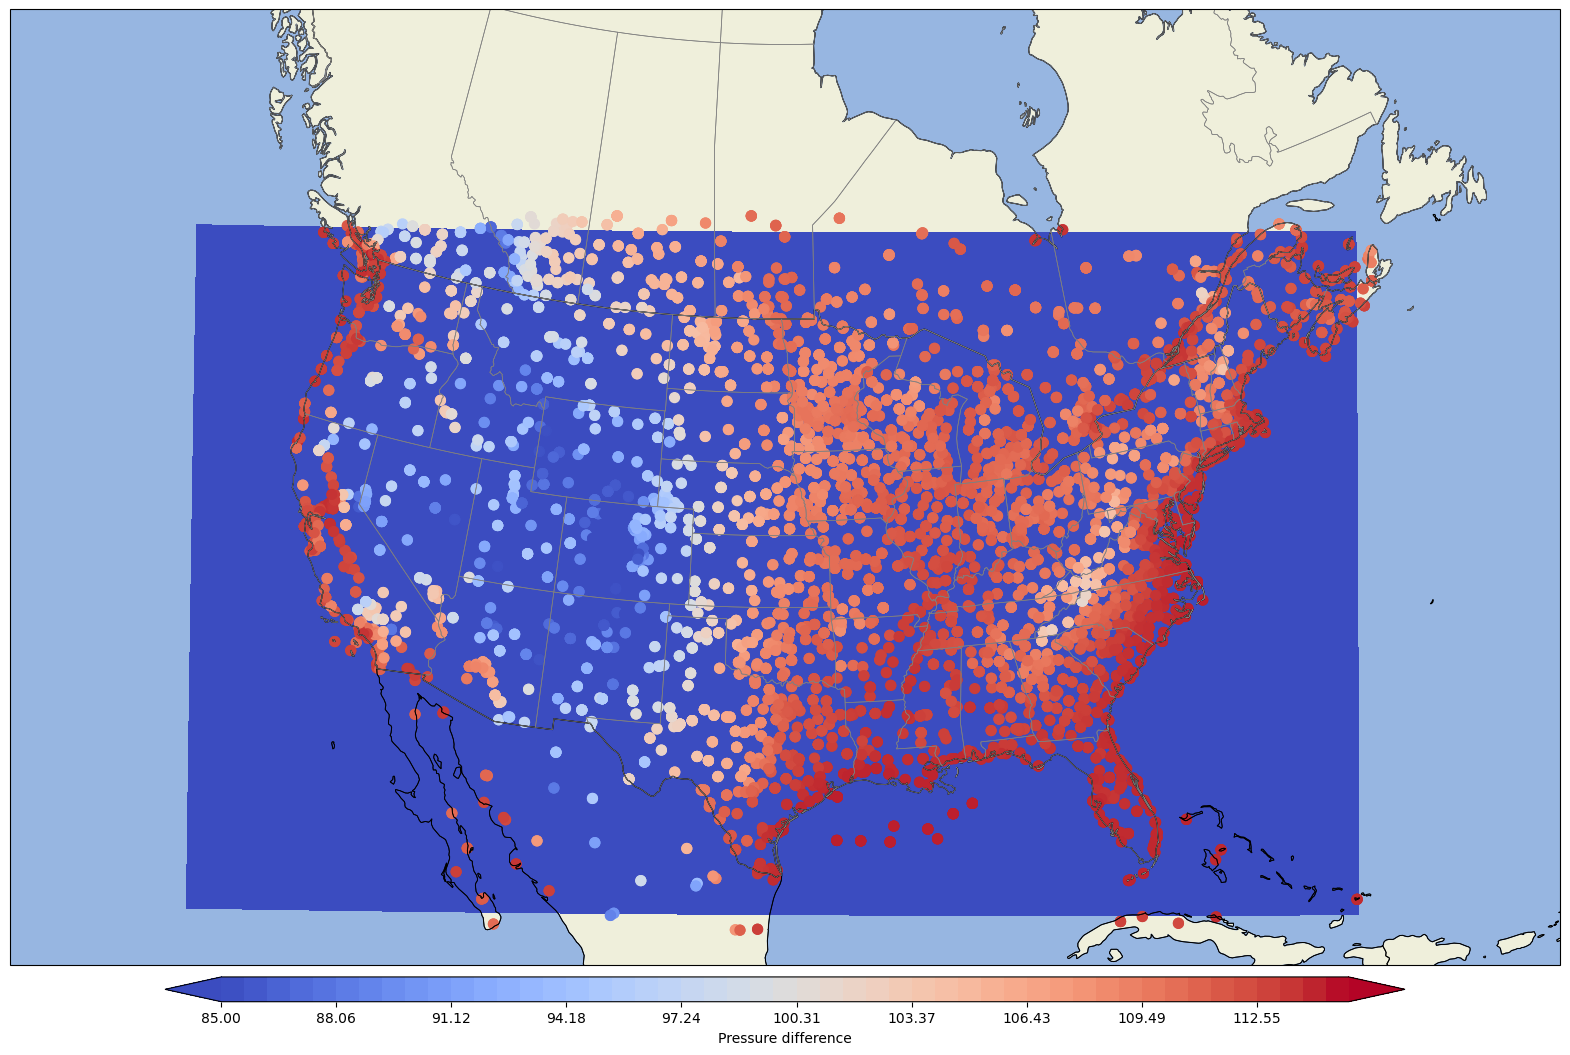

In [5]:
clat = 40
maxlat = 58
minlat = 22
maxlon = -63
minlon = -131
area = [minlon, maxlon, minlat, maxlat]

label_val_dict = {"Press_diff": ["Pressure difference", 85, 115],
                  #"Height_diff": ["Height difference", 900, 1100],
                  "Height_diff": ["Height difference", 260, 320],
                  "Lapserate": ["Lapse rate", -5, 15]}

fig = plt.figure(figsize=(20, 16))
cartopy.config['data_dir'] = "/work2/noaa/wrfruc/span/natural_earth_data"
projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40,
                                   standard_parallels=(clat-5, clat+5))
#projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
ax = plt.axes(projection=projection)
ax.set_extent(area, crs=ccrs.PlateCarree())

land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
ax.add_feature(land, zorder=0)

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['water'])
ax.add_feature(ocean, zorder=0)

# Add coastlines
coast = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='coastline')
ax.add_feature(coast, edgecolor='black', facecolor='none', linewidth=0.5)

# Add country borders
countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_0_countries')
ax.add_feature(countries, edgecolor='black', facecolor='none', linewidth=0.7)

# Add state lines
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_1_states_provinces')
ax.add_feature(states, edgecolor='gray', facecolor='none', linewidth=0.5)

vmin, vmax = label_val_dict[plot_var][1], label_val_dict[plot_var][2]

# Shade plot of the hrrr data
ct = ax.contourf(hrrr['Lons'][::subsample_factor, ::subsample_factor], 
                 hrrr['Lats'][::subsample_factor, ::subsample_factor], 
                 hrrr[plot_var][::subsample_factor, ::subsample_factor], 
                 levels=np.linspace(vmin, vmax, 50), cmap='coolwarm', 
                 transform=ccrs.PlateCarree(), extend='both')

# Scatter plot of the latitudes and longitudes
# 'Lat' is your latitude column, and 'Lon' is your longitude column
sc = ax.scatter(rrfs_df['Lons'], rrfs_df['Lats'], c=rrfs_df[plot_var], cmap='coolwarm', 
                vmin=vmin, vmax=vmax, 
                transform=ccrs.PlateCarree(), s=50)
cbar = plt.colorbar(ct, label=label_val_dict[plot_var][0], orientation='horizontal', shrink=0.8, aspect=50, pad=0.01)